In [22]:
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
from collections import deque
import random
import cv2
import collections
import gym
import numpy as np
from ptan.common.utils import TBMeanTracker as tb_tracker
import torch.nn.utils as nn_utils
import matplotlib.pyplot as plt

In [23]:
class ACNet(Module):
    def __init__(self, input_shape, n_actions):
        super(ACNet, self).__init__()
        
        self.linear_layers = Sequential(
        Linear(input_shape[0], 128),
        nn.ReLU(),
        Linear(128, n_actions)
        )
        
       
    
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
    def forward(self, x):
        return self.linear_layers(x)

class CNet(Module):
    def __init__(self, input_shape):
        super(CNet, self).__init__()
        self.linear_layers = Sequential(
        Linear(input_shape[0], 128),
        nn.ReLU(),
        Linear(128, 1))
    def forward(self, x):
        return self.linear_layers(x)
        
        
        
class Probability_Agent:
    def __init__(self, net, n_actions):
        
        self.nn = net
        self.actionspace = [i for i in range(n_actions)]
    
    def probability(self, action, softmax = True):
        if softmax:
            prob = F.softmax(action, dim =1)
            
        return prob
        
    def actions(self, state):
        
        state = torch.tensor([state], dtype = torch.float)#.to(self.nn.device)
        action = self.nn.forward(state)
        action_probs = self.probability(action)
        action_probs = action_probs.detach().numpy()
        action = np.random.choice(self.actionspace, p =action_probs[0])
        return action
    
         
def history_to_tensor(history):
    h = np.asarray(history).reshape(len(history),5)
    states, actions, newstates, rewards, dones = [],[],[],[],[]
    states.append([h[i][0] for i in range(len(h))])
    actions.append([h[i][1] for i in range(len(h))])
    newstates.append([h[i][2] for i in range(len(h))])
    rewards.append([h[i][3] for i in range(len(h))])
    dones.append([h[i][4] for i in range(len(h))])
    states = torch.tensor(states, dtype = torch.float)
    actions = torch.FloatTensor(actions)
    newstates = torch.tensor(newstates, dtype = torch.float)
    rewards = torch.FloatTensor(rewards)
    dones = torch.tensor(dones)

    return states, actions, newstates, rewards, dones, h


def batch_to_tensor(batch):
    states, actions, newstates, rewards, dones = [],[],[],[],[]
    states.append([batch[i][0] for i in range(len(batch))])
    actions.append([batch[i][1] for i in range(len(batch))])
    newstates.append([batch[i][2] for i in range(len(batch))])
    rewards.append([batch[i][3] for i in range(len(batch))])
    dones.append([batch[i][4] for i in range(len(batch))])
    states = torch.cat([states[0][i] for i in range(len(batch))], dim=1)
    actions = torch.cat([actions[0][i] for i in range(len(batch))], dim=1)
    newstates = torch.cat([newstates[0][i] for i in range(len(batch))], dim=1)
    rewards = torch.cat([rewards[0][i] for i in range(len(batch))], dim=1)#.reshape(num_envs,time_steps)
    dones = torch.cat([dones[0][i] for i in range(len(batch))], dim=1)
    return states, actions, newstates, rewards, dones
class ExperienceSource:
    def __init__(self):
        
        self.states = deque(maxlen=10)
        self.time_step = 0
    def __iter__(self):
        while True:
            if self.time_step == 0:
                rewards = deque(maxlen = 10)
                done = False
                states = []
                rewards = []
                histories = []
                done_rewards = deque(maxlen = 100)
                for env in envs:
                    state = env.reset()
                    states.append(state)
                    rewards.append(0)
                    histories.append(deque(maxlen = 1))    
            actions = []
           # envs[0].render()
            for idx, (env, state) in enumerate(zip(envs, states)):
                action = agent.actions(state)
                actions.append(action)
                
            for i, (env, action) in enumerate(zip(envs, np.asarray(actions))):
                history = histories[i]
                newstate, reward, done, _ = env.step(action)
                history.append([states[i], action, newstate, reward, done])
                if done:
                    states[i] = env.reset()
                    done_rewards.append(rewards[i])
                    rewards[i] = 0
                else:
                    states[i] = newstate
                    #print('updating')
                    rewards[i] += reward
            self.time_step += 1
            
            yield histories, np.mean(done_rewards)    

In [25]:
timesteps = 5
gamma = 0.99
clip_ratio = 0.2
ratios, clippeds, surrogates, c_surrogates, log_probs, lp_buffers = [],[],[],[],[],[]


In [26]:
time_steps = 5
num_envs = 1
#env_name = 'LunarLander-v2'
env_name = 'CartPole-v0'
envs = []
for i in range(num_envs):
    envs.append(gym.make(env_name))
actor = ACNet(envs[0].observation_space.shape, envs[0].action_space.n)
critic = CNet(envs[0].observation_space.shape)
coptimizer = optim.Adam(critic.parameters(), lr = 0.003, eps = 1e-3)
aoptimizer = optim.Adam(actor.parameters(), lr = 0.003, eps = 1e-3)
agent = Probability_Agent(actor, envs[0].action_space.n)      


vloss, ploss,dr = [],[],[]
exp_source = iter(ExperienceSource())
def cal_advantage(states, rewards):
    nextvalue = torch.zeros(timesteps,len(envs))
    value = critic.forward(states)
    rewards, value = rewards.reshape(timesteps,len(envs)), \
                                value.reshape(timesteps,len(envs))
    for i in range(timesteps-1):
        nextvalue[i] = value[i+1]
        
    advantages,qval,val = 0,0,0

    for i in range(timesteps-1):
        advantages += (rewards[i] + gamma* nextvalue[i] - value[i])* gamma**i 
        qval += (rewards[i] + gamma* nextvalue[i])* gamma**i
        val += value[i] * gamma**i
    return advantages, qval, val

def policy_loss(advantages, lp_buffer, actions):
    logits = actor.forward(states)
    c = Categorical(F.softmax(logits, dim=1))
   # log_prob = F.log_softmax(logits, dim=1)
    log_prob = c.log_prob(actions)
    if len(lp_buffer) == 0:
        old_logprob = log_prob.detach()
    else:
        old_logprob = lp_buffer[0]
           
    lp_buffer.append(log_prob.detach())
    ratio = torch.exp(log_prob - old_logprob)
    clipped = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio)
    
    def reshape(ratio):
        lps = []
        for x in range(len(envs)):
            lps.append(ratio[0][[i for i in range(x,50,10)]])
        
        lps = torch.stack(lps)
        return lps    
   # ratio, clipped = reshape(ratio), reshape(clipped)
    surrogate = ratio*advantages#.reshape(len(envs),1)#,1)
    c_surrogate = clipped * advantages#.reshape(len(envs),1)#,1)
    ratios.append(ratio)
    clippeds.append(clipped)
    surrogates.append(surrogate)
    c_surrogates.append(c_surrogate)
    log_probs.append(log_prob)
    lp_buffers.append(lp_buffer)
    return -(torch.min(surrogate,c_surrogate)).mean()

lp_buffer = deque(maxlen = 1)   
batch = []

for r, (exp, done_rewards) in enumerate(exp_source):
    states,actions, nextstates, rewards, dones, _ = history_to_tensor(exp)
    batch.append([states,actions,nextstates,rewards,dones])
    if len(batch) < timesteps:
        continue
    states,actions,nextstates,rewards, dones = batch_to_tensor(batch)
    batch.clear()
    
    coptimizer.zero_grad()
    value = critic.forward(states)
    advantages, qval, val = cal_advantage(states, rewards)
    loss = F.mse_loss(qval, value)
    loss.backward()
    coptimizer.step()

    aoptimizer.zero_grad()
    loss_pl = policy_loss(advantages.detach(), lp_buffer, actions)
    loss_pl.backward()
    aoptimizer.step()
    
    
    if r % 3 == 0:

        print(r,'rewards:', done_rewards)
        dr.append(done_rewards)
        vloss.append(loss)
        ploss.append(loss_pl)
       # av.append(advantage.mean())
       # v.append(value.mean())
        
       # RR.append(R.mean())
       # e.append(entropy_loss)
        #pl.append(policy_loss)
       #lv.append(loss_v)
       # tl.append(tloss)
       # gr.append(np.sqrt(np.mean(np.square(grads))) )
    #if r == 10:
        
     #   break

/opt/anaconda3/envs/ml4t/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Using a target size (torch.Size([1, 5, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


9 rewards: nan
24 rewards: nan
39 rewards: nan
54 rewards: nan
69 rewards: nan
84 rewards: nan
99 rewards: nan
114 rewards: nan
129 rewards: 117.0
144 rewards: 117.0
159 rewards: 117.0
174 rewards: 117.0
189 rewards: 117.0
204 rewards: 117.0
219 rewards: 107.0
234 rewards: 107.0
249 rewards: 107.0
264 rewards: 107.0
279 rewards: 88.0
294 rewards: 88.0
309 rewards: 76.5
324 rewards: 76.5
339 rewards: 76.5
354 rewards: 76.5
369 rewards: 71.2
384 rewards: 71.2
399 rewards: 71.2
414 rewards: 71.2
429 rewards: 68.66666666666667
444 rewards: 68.66666666666667
459 rewards: 68.66666666666667
474 rewards: 68.66666666666667
489 rewards: 68.66666666666667
504 rewards: 70.0
519 rewards: 70.0
534 rewards: 70.0
549 rewards: 67.125
564 rewards: 67.125
579 rewards: 67.125
594 rewards: 67.125
609 rewards: 65.33333333333333
624 rewards: 65.33333333333333
639 rewards: 65.33333333333333
654 rewards: 65.33333333333333
669 rewards: 65.33333333333333
684 rewards: 65.33333333333333
699 rewards: 68.9
714 rewar

4674 rewards: 84.67924528301887
4689 rewards: 84.67924528301887
4704 rewards: 86.07407407407408
4719 rewards: 86.07407407407408
4734 rewards: 86.07407407407408
4749 rewards: 86.07407407407408
4764 rewards: 86.07407407407408
4779 rewards: 86.07407407407408
4794 rewards: 85.96363636363637
4809 rewards: 85.96363636363637
4824 rewards: 85.96363636363637
4839 rewards: 85.96363636363637
4854 rewards: 85.96363636363637
4869 rewards: 85.96363636363637
4884 rewards: 85.96363636363637
4899 rewards: 85.96363636363637
4914 rewards: 85.96363636363637
4929 rewards: 85.96363636363637
4944 rewards: 85.96363636363637
4959 rewards: 85.96363636363637
4974 rewards: 85.96363636363637
4989 rewards: 87.98214285714286
5004 rewards: 87.98214285714286
5019 rewards: 87.98214285714286
5034 rewards: 87.98214285714286
5049 rewards: 87.98214285714286
5064 rewards: 87.98214285714286
5079 rewards: 87.98214285714286
5094 rewards: 87.98214285714286
5109 rewards: 87.98214285714286
5124 rewards: 87.98214285714286
5139 rew

8784 rewards: 104.6144578313253
8799 rewards: 104.6144578313253
8814 rewards: 104.6144578313253
8829 rewards: 104.6144578313253
8844 rewards: 104.6144578313253
8859 rewards: 104.6144578313253
8874 rewards: 104.6144578313253
8889 rewards: 104.6144578313253
8904 rewards: 104.6144578313253
8919 rewards: 104.6144578313253
8934 rewards: 104.6144578313253
8949 rewards: 104.6144578313253
8964 rewards: 104.6144578313253
8979 rewards: 105.73809523809524
8994 rewards: 105.73809523809524
9009 rewards: 105.73809523809524
9024 rewards: 105.73809523809524
9039 rewards: 105.73809523809524
9054 rewards: 105.73809523809524
9069 rewards: 105.73809523809524
9084 rewards: 105.73809523809524
9099 rewards: 105.73809523809524
9114 rewards: 105.73809523809524
9129 rewards: 105.73809523809524
9144 rewards: 105.73809523809524
9159 rewards: 105.73809523809524
9174 rewards: 106.83529411764705
9189 rewards: 106.83529411764705
9204 rewards: 106.83529411764705
9219 rewards: 106.83529411764705
9234 rewards: 106.83529

12924 rewards: 123.93
12939 rewards: 123.93
12954 rewards: 123.93
12969 rewards: 123.93
12984 rewards: 123.93
12999 rewards: 123.93
13014 rewards: 123.93
13029 rewards: 123.93
13044 rewards: 123.93
13059 rewards: 125.36
13074 rewards: 125.36
13089 rewards: 125.36
13104 rewards: 125.36
13119 rewards: 125.36
13134 rewards: 125.36
13149 rewards: 125.36
13164 rewards: 125.36
13179 rewards: 125.36
13194 rewards: 125.36
13209 rewards: 125.36
13224 rewards: 125.36
13239 rewards: 125.36
13254 rewards: 126.51
13269 rewards: 126.51
13284 rewards: 126.51
13299 rewards: 126.51
13314 rewards: 126.51
13329 rewards: 126.51
13344 rewards: 126.51
13359 rewards: 126.51
13374 rewards: 126.51
13389 rewards: 126.51
13404 rewards: 126.51
13419 rewards: 126.51
13434 rewards: 126.51
13449 rewards: 128.03
13464 rewards: 128.03
13479 rewards: 128.03
13494 rewards: 128.03
13509 rewards: 128.03
13524 rewards: 128.03
13539 rewards: 128.03
13554 rewards: 128.03
13569 rewards: 128.03
13584 rewards: 128.03
13599 rewa

18759 rewards: 159.05
18774 rewards: 159.05
18789 rewards: 159.05
18804 rewards: 159.05
18819 rewards: 159.05
18834 rewards: 159.05
18849 rewards: 160.11
18864 rewards: 160.11
18879 rewards: 160.11
18894 rewards: 160.11
18909 rewards: 160.11
18924 rewards: 160.11
18939 rewards: 160.11
18954 rewards: 160.11
18969 rewards: 160.11
18984 rewards: 160.11
18999 rewards: 160.11
19014 rewards: 160.11
19029 rewards: 160.11
19044 rewards: 160.11
19059 rewards: 161.38
19074 rewards: 161.38
19089 rewards: 161.38
19104 rewards: 161.38
19119 rewards: 161.38
19134 rewards: 161.38
19149 rewards: 161.38
19164 rewards: 161.38
19179 rewards: 161.38
19194 rewards: 161.38
19209 rewards: 161.38
19224 rewards: 161.38
19239 rewards: 161.38
19254 rewards: 162.49
19269 rewards: 162.49
19284 rewards: 162.49
19299 rewards: 162.49
19314 rewards: 162.49
19329 rewards: 162.49
19344 rewards: 162.49
19359 rewards: 162.49
19374 rewards: 162.49
19389 rewards: 162.49
19404 rewards: 162.49
19419 rewards: 162.49
19434 rewa

24429 rewards: 184.23
24444 rewards: 184.23
24459 rewards: 184.64
24474 rewards: 184.64
24489 rewards: 184.64
24504 rewards: 184.64
24519 rewards: 184.64
24534 rewards: 184.64
24549 rewards: 184.64
24564 rewards: 184.64
24579 rewards: 184.64
24594 rewards: 184.64
24609 rewards: 184.64
24624 rewards: 184.64
24639 rewards: 184.64
24654 rewards: 185.55
24669 rewards: 185.55
24684 rewards: 185.55
24699 rewards: 185.55
24714 rewards: 185.55
24729 rewards: 185.55
24744 rewards: 185.55
24759 rewards: 185.55
24774 rewards: 185.55
24789 rewards: 185.55
24804 rewards: 185.55
24819 rewards: 185.55
24834 rewards: 185.55
24849 rewards: 186.75
24864 rewards: 186.75
24879 rewards: 186.75
24894 rewards: 186.75
24909 rewards: 186.75
24924 rewards: 186.75
24939 rewards: 186.75
24954 rewards: 186.75
24969 rewards: 186.75
24984 rewards: 186.75
24999 rewards: 186.75
25014 rewards: 186.75
25029 rewards: 186.75
25044 rewards: 186.75
25059 rewards: 187.47
25074 rewards: 187.47
25089 rewards: 187.47
25104 rewa

30129 rewards: 196.72
30144 rewards: 196.72
30159 rewards: 196.72
30174 rewards: 196.72
30189 rewards: 196.72
30204 rewards: 196.72
30219 rewards: 196.72
30234 rewards: 196.72
30249 rewards: 196.72
30264 rewards: 196.72
30279 rewards: 196.72
30294 rewards: 196.72
30309 rewards: 196.72
30324 rewards: 196.72
30339 rewards: 196.72
30354 rewards: 196.72
30369 rewards: 196.72
30384 rewards: 196.72
30399 rewards: 196.72
30414 rewards: 196.72
30429 rewards: 196.72
30444 rewards: 196.72
30459 rewards: 196.85
30474 rewards: 196.85
30489 rewards: 196.85
30504 rewards: 196.85
30519 rewards: 196.85
30534 rewards: 196.85
30549 rewards: 196.85
30564 rewards: 196.85
30579 rewards: 196.85
30594 rewards: 196.85
30609 rewards: 196.85
30624 rewards: 196.85
30639 rewards: 196.85
30654 rewards: 197.53
30669 rewards: 197.53
30684 rewards: 197.53
30699 rewards: 197.53
30714 rewards: 197.53
30729 rewards: 197.53
30744 rewards: 197.53
30759 rewards: 197.53
30774 rewards: 197.53
30789 rewards: 197.53
30804 rewa

KeyboardInterrupt: 

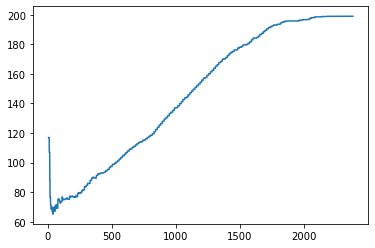

In [28]:
plt.plot(dr)
